In [375]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import numpy as np

In [383]:
df = pd.read_json('data/outdoor_temp_data/temp.json')
df= pd.DataFrame(df['observations']['data'])
df['aifstime_utc'] = pd.to_datetime(df['aifstime_utc'])

In [384]:
df = df.drop(['sort_order','wmo','local_date_time','local_date_time_full','name','history_product','lat', 
                                               'lon',  'wind_dir', 'cloud', 'cloud_type', 'press_tend', 
                                               'swell_dir_worded', 'weather', 'sea_state', 'cloud_base_m', 
                                               'cloud_oktas', 'cloud_type_id', 'swell_height','swell_period'],axis=1)
df = df.set_index('aifstime_utc')

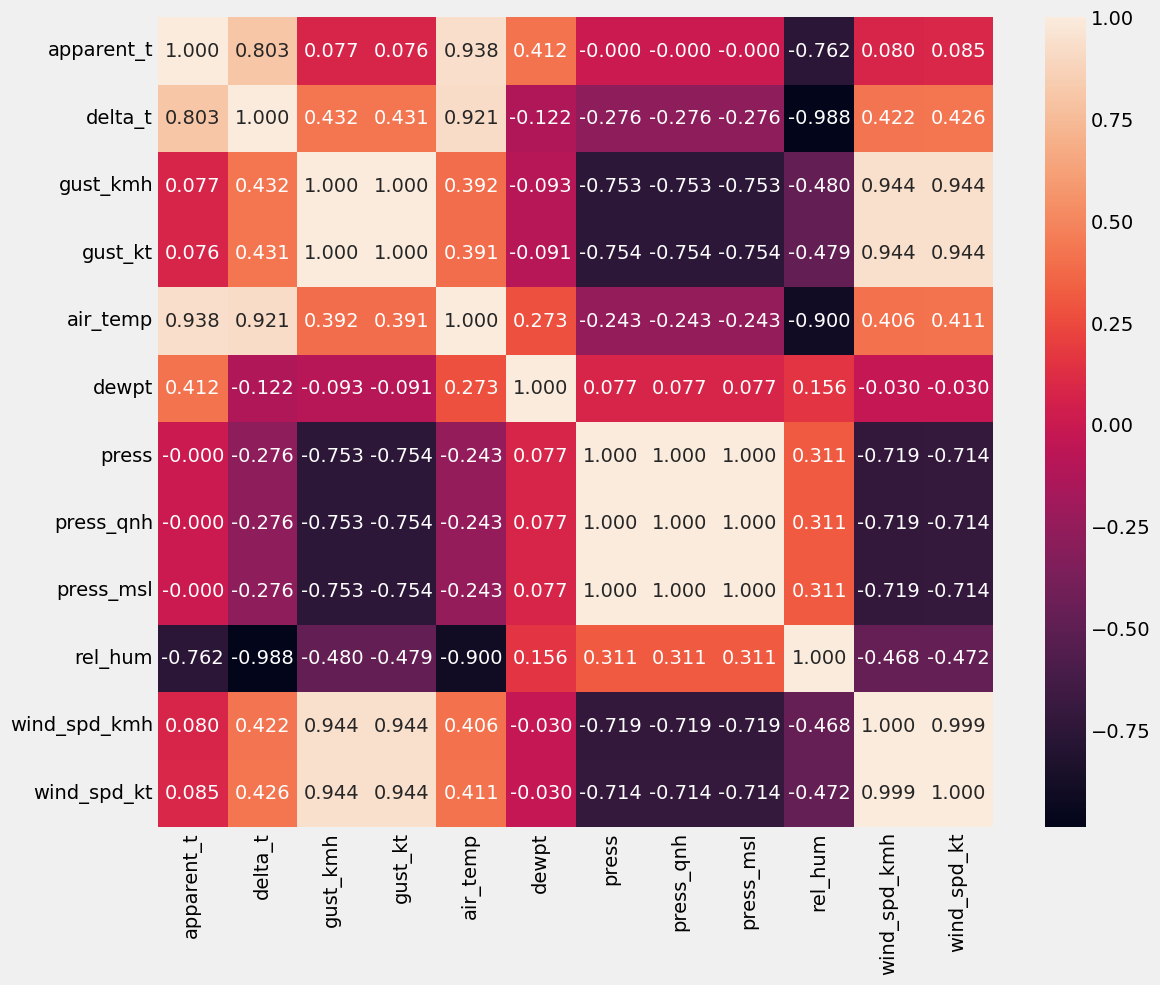

In [385]:
corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrMatrix, annot= True, ax=ax, fmt='.3f')
plt.show()


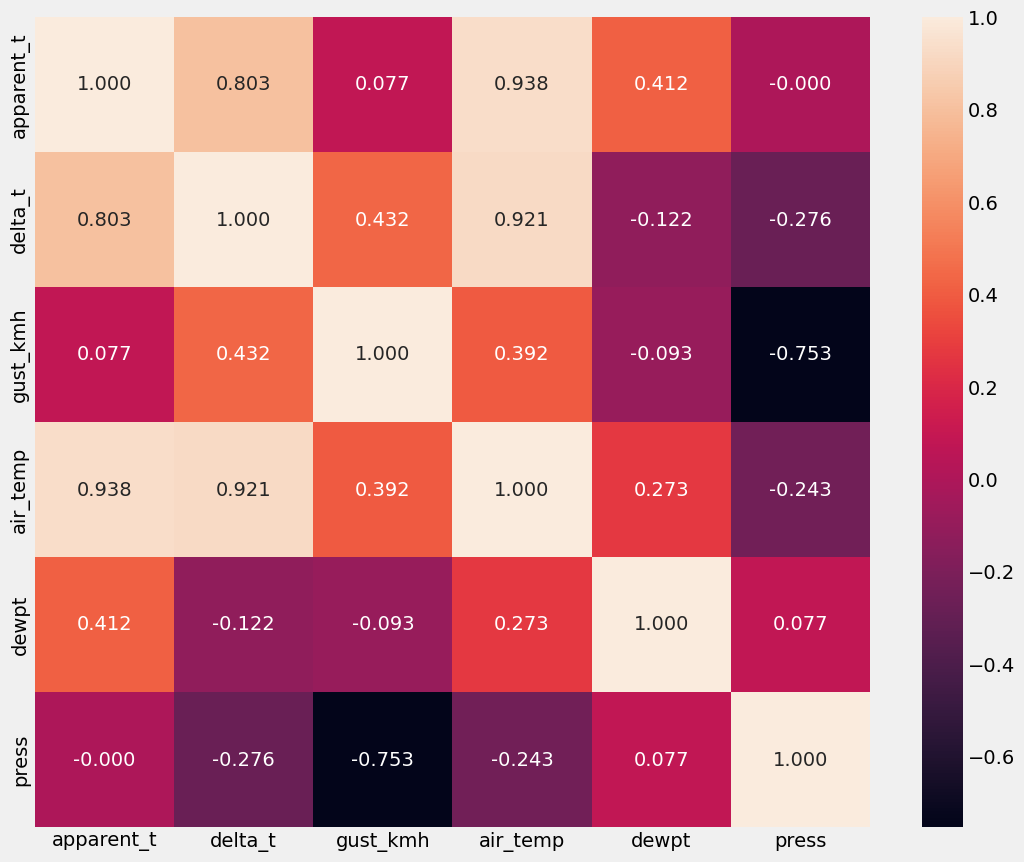

In [387]:
corr_matrix = df.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.94)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrMatrix, annot= True, ax=ax, fmt='.3f')
plt.show()


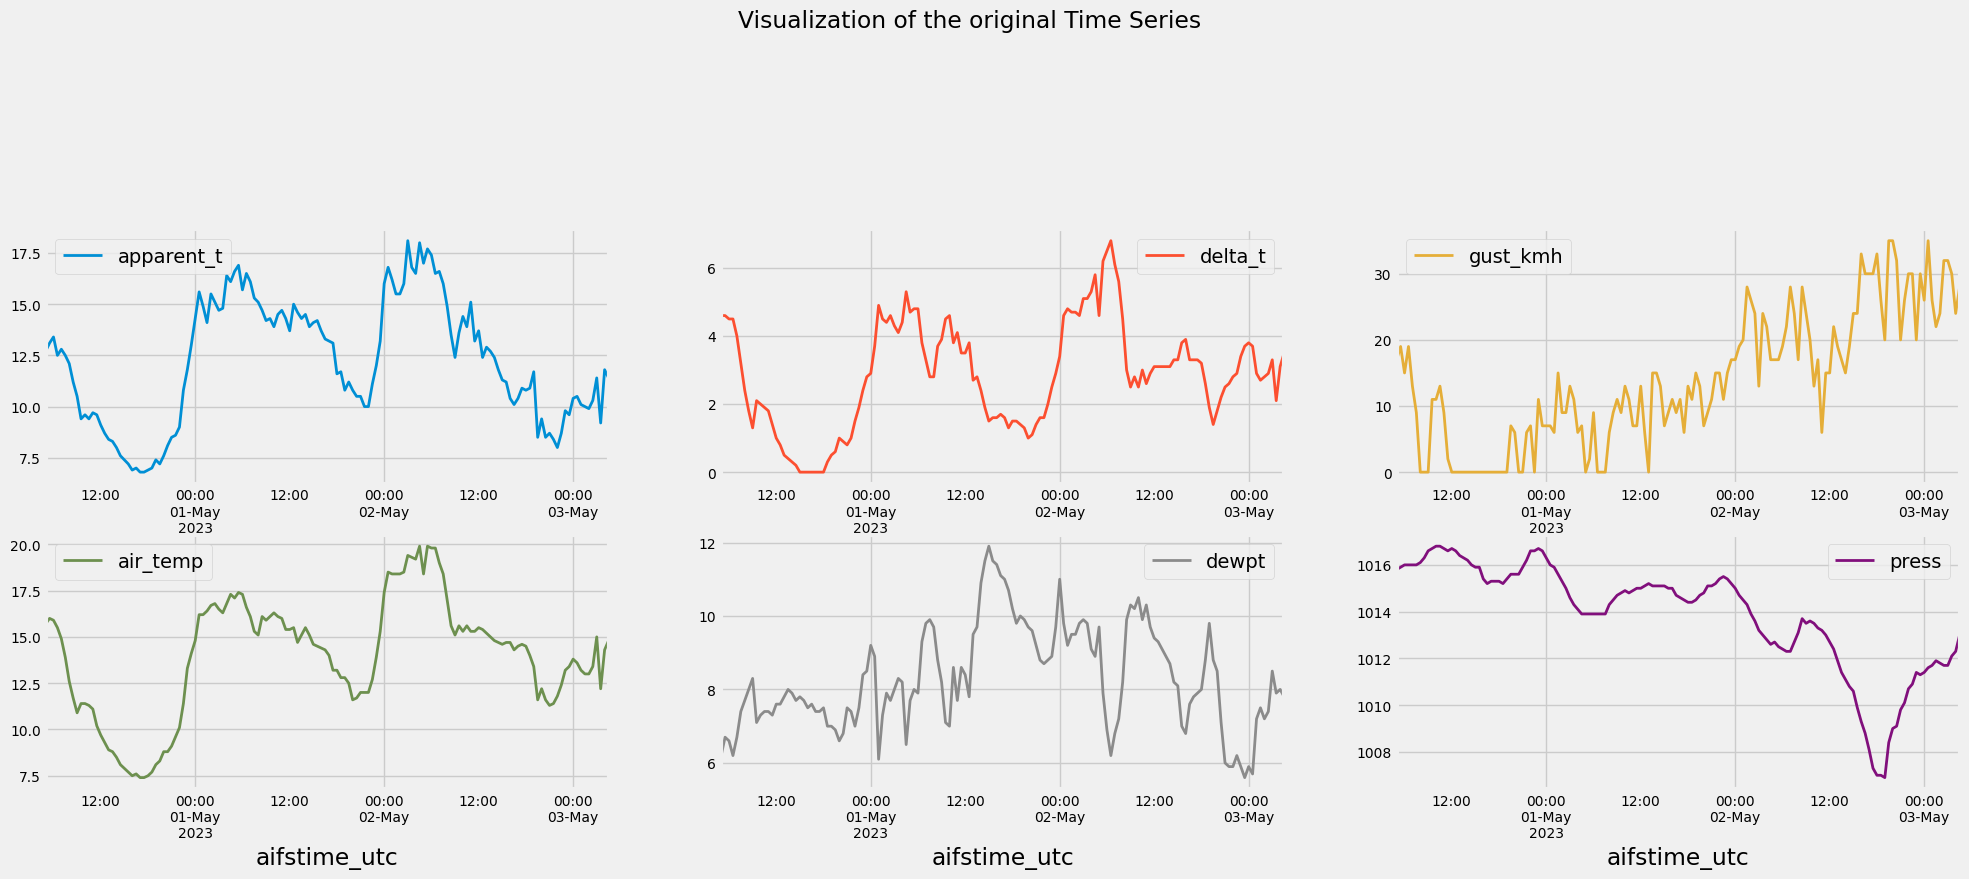

In [388]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

In [389]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [390]:
# put the df in an ascending order (respect to time)
df = df.iloc[::-1]

In [391]:
training_size = int ( 0.6 * df.shape[0])  
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:]

86 (144, 8)


For each prediction we will use last 1 day to predict the next
2\*24\*1 = 48
to predict 30 min into future, i.e. 1 point
to predict 24 hours i.e. 48

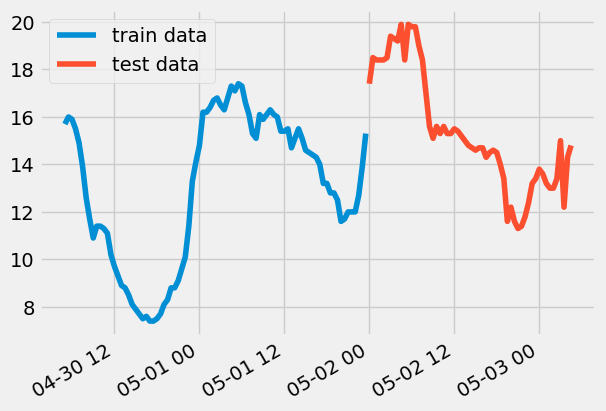

In [392]:
plt.plot(train_data.index, train_data[['air_temp']], label = 'train data')
plt.plot(val_data.index, val_data[['air_temp']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()

In [393]:
from time import time

In [394]:
# split the data into inputs and targets
past = 48
future = 24
step = 2  # one data point per 30 minutes
sequence_length = (past/step) # 24 hours of data for each input

# I want to use a T-days window of input data for predicting target_class
# It means I need to prepend (T-1) last train records to the 1st test window
T = past  # my choice of the timesteps window
pred_T = future
train_features, train_labels  = train_data.drop('air_temp',axis=1), train_data[['air_temp']]
test_features, test_labels = val_data.drop('air_temp',axis=1), val_data[['air_temp']]

prepend_features = train_features.iloc[-(T-1):]
test_features = pd.concat([prepend_features, test_features], axis=0)

print(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)


# Create sequences of T timesteps (=sliding window)
# Normalize sequences X = X/X_0-1, where X_0 is 1st timestep in the window:
X_train, y_train = [], []
for i in range(train_labels.shape[0] - (T+pred_T-1)):
    X_train.append(train_features.iloc[i:i+T])
    y_train.append(train_labels.iloc[i + (T-1):i + (T-1)+pred_T])
X_train, y_train = np.array(X_train), np.array(y_train)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(test_labels.shape[0]-pred_T):
    X_test.append(test_features.iloc[i:i+T])
    y_test.append(test_labels.iloc[i:i+pred_T])
X_test, y_test = np.array(X_test), np.array(y_test)
print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape).reshape(-1,future)

X_test= scaler_x.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test= scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape).reshape(-1,future)

print(f'(after normalisation) y data dimensions: {y_test.shape}, {y_train.shape}')



(86, 7) (86, 1) (105, 7) (58, 1)
Train data dimensions: (15, 48, 7), (15, 24, 1)
Test data dimensions: (34, 48, 7), (34, 24, 1)
(after normalisation) y data dimensions: (34, 24), (15, 24)


layers=[96, 48, 48, 24], train_examples=15, test_examples=34
batch = 256, timesteps = 48, features = 7, epochs = 50
lr = 0.1, lambda = 0.05, dropout = 0.0, recurr_dropout = 0.0
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (None, 48, 96)            39936     
_________________________________________________________________
lstm_106 (LSTM)              (None, 48, 48)            27840     
_________________________________________________________________
lstm_107 (LSTM)              (None, 48)                18624     
_________________________________________________________________
dense_51 (Dense)             (None, 24)                1176      
Total params: 87,576
Trainable params: 87,576
Non-trainable params: 0
_________________________________________________________________
None
-----------------------------------------------------------------

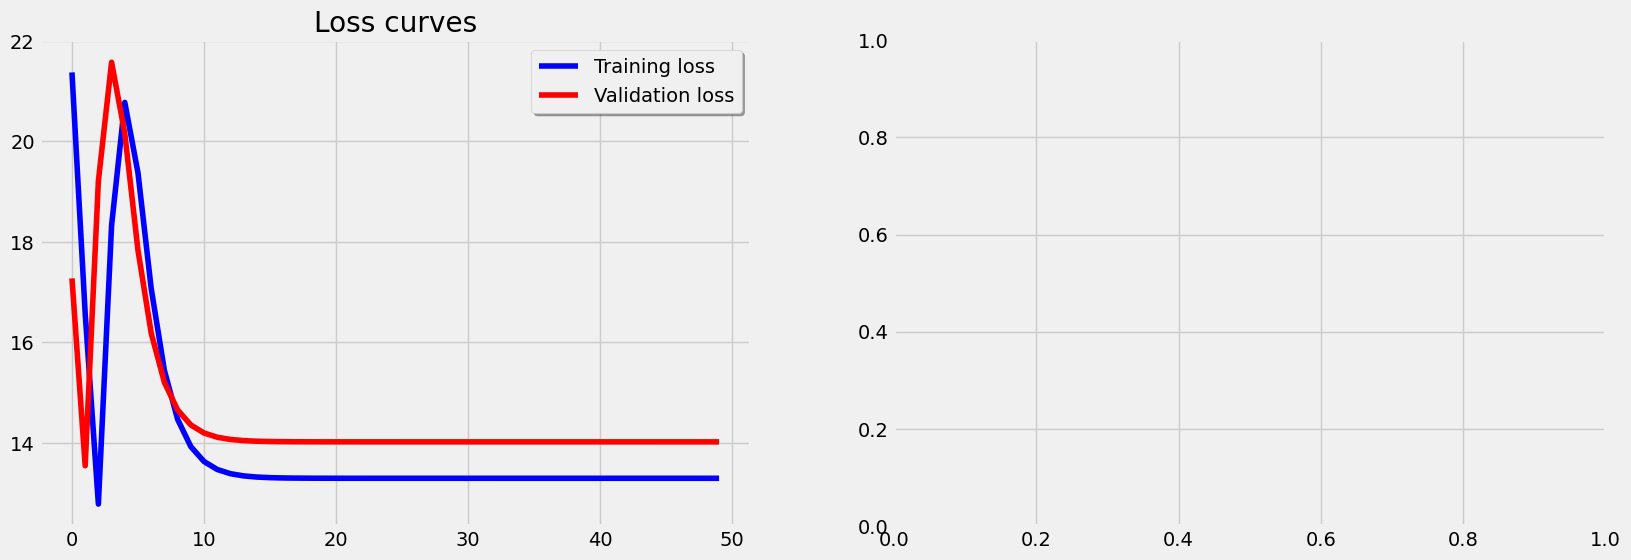

average temperature error: -0.07208523984048876
 mse: 3.71980686601945


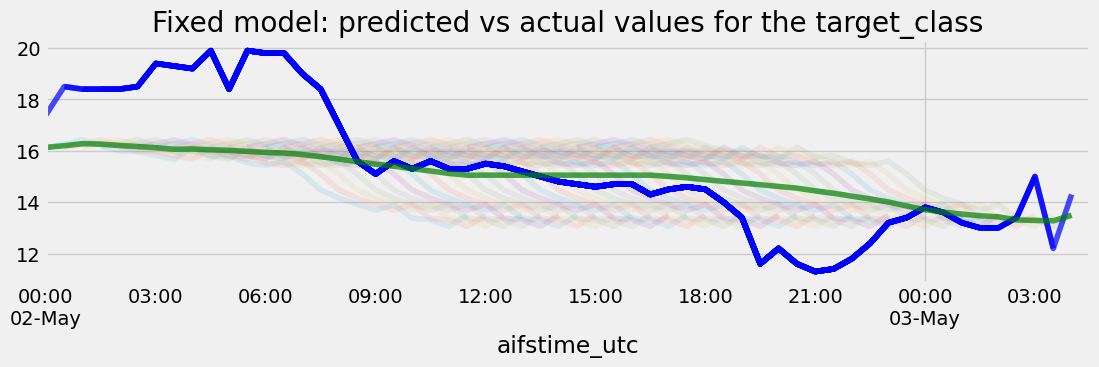

In [395]:

# Let's make a list of CONSTANTS for modelling:
LAYERS = [future*4, future*2, future*2, future]             # number of units in hidden and output layers
M_TRAIN = X_train.shape[0]           # number of training examples (2D)
M_TEST = X_test.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train.shape[2]                 # number of features
BATCH = 256                          # batch size
EPOCH = 50                           # number of epochs
LR = 1e-1                            # learning rate of the gradient descent
LAMBD = 5e-2                         # lambda in L2 regularizaion
DP = 0.00                            # dropout rate
RDP = 0.00                           # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')


# inputs = keras.layers.Input(shape=(T,N))
# lstm_out = keras.layers.LSTM(32)(inputs)
# outputs = keras.layers.Dense(future)(lstm_out)
# model = keras.Model(name="Weather_forcaster",inputs=inputs, outputs=outputs)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
# print(model.summary())

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[1],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=True, return_state=False,
            stateful=False, unroll=False))
model.add(LSTM(units=LAYERS[2],
            activation='tanh', recurrent_activation='hard_sigmoid',
            kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            dropout=DP, recurrent_dropout=RDP,
            return_sequences=False, return_state=False,
            stateful=False, unroll=False))
model.add(Dense(units=LAYERS[3]))





# # Build the Model
# model = Sequential()
# model.add(LSTM(input_shape=(T,N), units=LAYERS[0],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=True, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(LSTM(units=LAYERS[1],
#             # activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=True, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(LSTM(units=LAYERS[2],
#             activation='tanh', recurrent_activation='hard_sigmoid',
#             kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
#             dropout=DP, recurrent_dropout=RDP,
#             return_sequences=False, return_state=False,
#             stateful=False, unroll=False))
# model.add(BatchNormalization())
# model.add(Dense(units=LAYERS[3]))

# Compile the model with Adam optimizer
model.compile(loss='mse', metrics=['accuracy'],
            optimizer=Adam(lr=LR))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', patience=1, verbose=0, 
                            factor=0.5, min_lr=1e-8)
# # Define Early Stopping:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
#                         patience=10, verbose=1, mode='auto',
#                         baseline=0, restore_best_weights=False)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()
History = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,
                    validation_split=0.2, shuffle=True,verbose=0, callbacks=[lr_decay])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_acc = History.history['accuracy'][-1]    #model.evaluate(X_train, y_train, batch_size=M_TRAIN)
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=M_TEST)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 2)}%')
print(f'fixed model test score = {round(test_acc * 100, 2)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
plt.show()

# Plot predictions vs actual labels for fixed model
# print()
# index = test_features.set_index(test_features[0]).drop(test_features.columns[0], axis=1).index


## for large amount
fixed_predict = model.predict_on_batch(X_test)
j = 0
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Fixed model: predicted vs actual values for the target_class')
dff_avg = pd.DataFrame({'predicted':  np.full(test_labels.shape[0], np.nan)},index=test_labels.index)
avg_temperr=0
avg_mse=0
for i in range(fixed_predict.shape[0]):
    averaged = scaler_y.inverse_transform(fixed_predict)[i]
    # Plot predictions vs actual labels for fixed model
    actual = scaler_y.inverse_transform(y_test)[i]
    index = test_labels.iloc[i:i+actual.shape[0]].index

    # print(fixed_predict)
    dff1 = pd.DataFrame({f'predicted': averaged.squeeze()}, index=index)
  
    # Assuming dff1 and dff2 are two dataframes with different index lengths
    # Join the two dataframes on their index
    dff_avg = dff_avg.join(dff1, how='left', rsuffix=f'_{i}')
    dff2 = pd.DataFrame({'actual': actual.squeeze()}, index=index)
    dff1.plot(ax=ax, alpha=0.1, legend=False)
    dff2.plot(ax=ax, alpha=0.7, color='blue', legend=False)
    avg_temperr +=np.mean(dff1['predicted']-dff2['actual'])
    avg_mse +=mean_squared_error(dff1['predicted'], dff2['actual'])
dff_avg= dff_avg.mean(axis=1)
dff_avg.plot(ax=ax, alpha=0.7, color='green', legend=False)
print(f"average temperature error: {avg_temperr/fixed_predict.shape[0]}")
print(f" mse: {avg_mse/fixed_predict.shape[0]}")
plt.show()

#### for single prediction
# fixed_predict = model.predict_on_batch(X_test)
# averaged = np.mean(fixed_predict[:,3:6,:], axis=1)
# # Plot predictions vs actual labels for fixed model
# index = test_labels.index
# # print(fixed_predict)
# dff = pd.DataFrame({'predicted':scaler_y.inverse_transform(averaged).squeeze(), 'actual':scaler_y.inverse_transform(y_test).squeeze()}, index=index)
# # dff = pd.DataFrame({'predicted':averaged.squeeze(), 'actual':y_test.squeeze()}, index=index)
# ax = dff.plot(figsize=(12,3))
# ax.set_title('Fixed model: predicted vs actual values for the target_class')
# plt.show()
# print(f"average temperature error: {np.mean(dff['predicted']-dff['actual'])}")
# print(f" mse: {mean_squared_error(dff['predicted'], dff['actual'])}")

# for i in range(y_test.shape[1]):
#     fixed_score = np.sum(fixed_predict[:,i] == y_test[:,i]) / y_test.shape[0]
#     print(f'Fixed model test score = {round(fixed_score*100, 2)}%')
#     dff = pd.DataFrame({'predicted':fixed_predict[:,i].squeeze(), 'actual':y_test[:,i].squeeze()}, index=index)
#     ax = dff.plot(figsize=(12,3))
#     ax.set_title('Fixed model: predicted vs actual values for the target_class')
#     plt.show()

online model training

Online model instantiated in 0.92 secs
Online learning completed in 12.27 secs
(34, 24)
(58,)
average cum temperature error: -0.07208523282817761
 cum mse: 3.719802826208122
mean temp error:  -0.40527443430719723 mse:  3.5853140600704005


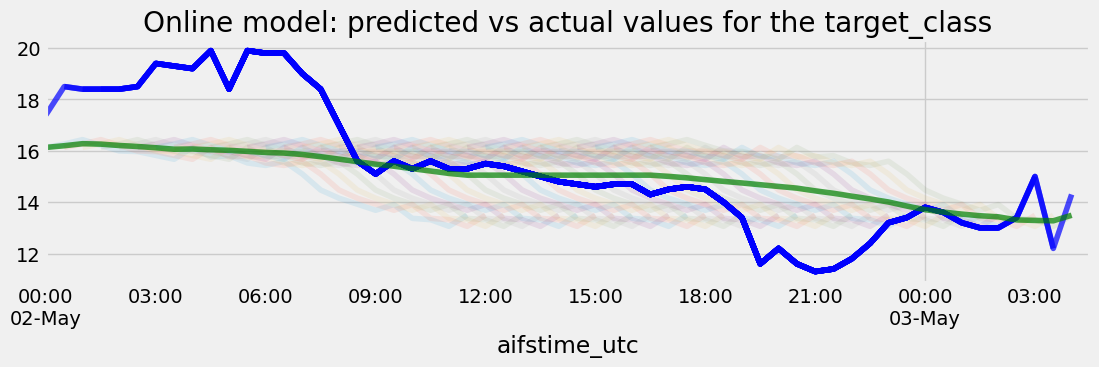

In [396]:
start = time()
config, weights = model.get_config(), model.get_weights()
online_model = Sequential.from_config(config)
online_model.set_weights(weights)
online_model.compile(loss='mse', optimizer=Adam(lr=LR))
print(f'Online model instantiated in {time() - start:.2f} secs')

# Online training (update model with each new data available):
predictions = []
start = time()
for t in range(y_test.shape[0]):
    x = X_test[t].reshape(-1,T,N)  # a "new" input is available
    y_hat = model.predict_on_batch(x) # predict on the "new" input
    # averaged = np.mean(y_hat[:,3:6,:], axis=1)
    predictions.append(y_hat)  # save predictions
    y = y_test[t].reshape(-1,1)   # a "new" label is available
    model.train_on_batch(x, y)  # runs a single gradient update 
print(f'Online learning completed in {time() - start:.2f} secs')


# # Evaluation of the predictions with online learning
# online_predict = np.array(predictions).reshape(-1,1)
# dff = pd.DataFrame({'predicted':scaler_y.inverse_transform(online_predict).squeeze(), 'actual':scaler_y.inverse_transform(y_test).squeeze()}, index=index)
# ax = dff.plot(figsize=(12,3))
# ax.set_title('Fixed model: predicted vs actual values for the target_class')
# plt.show()
# print(f"average temperature error: {np.mean(dff['predicted']-dff['actual'])}")
# print(f" mse: {mean_squared_error(dff['predicted'], dff['actual'])}")

## for large amount
fixed_predict = np.array(predictions)
fixed_predict = fixed_predict.reshape(fixed_predict.shape[0],-1)
print(fixed_predict.shape)
j = 0
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Online model: predicted vs actual values for the target_class')
dff_avg = pd.DataFrame({'predicted':  np.full(test_labels.shape[0], np.nan)},index=test_labels.index)
dff_actual = pd.DataFrame({'actual':  np.array(test_labels).reshape(-1)},index=test_labels.index)
avg_temperr=0
avg_mse=0
j=0
for i in range(fixed_predict.shape[0]):
    averaged = scaler_y.inverse_transform(fixed_predict)[i]
    # Plot predictions vs actual labels for fixed model
    actual = scaler_y.inverse_transform(y_test)[i]
    index = test_labels.iloc[i:i+actual.shape[0]].index

    # print(fixed_predict)
    dff1 = pd.DataFrame({'predicted': averaged.squeeze()}, index=index)
    j+=1
    # Assuming dff1 and dff2 are two dataframes with different index lengths
    # Join the two dataframes on their index
    dff_avg = dff_avg.join(dff1, how='left', rsuffix=f'_{i}')
    dff2 = pd.DataFrame({'actual': actual.squeeze()}, index=index)
    dff1.plot(ax=ax, alpha=0.1, legend=False)
    dff2.plot(ax=ax, alpha=0.7, color='blue', legend=False)
    avg_temperr +=np.mean(dff1['predicted']-dff2['actual'])
    avg_mse +=mean_squared_error(dff1['predicted'], dff2['actual'])
dff_avg= dff_avg.mean(axis=1)
print(dff_avg.values.shape)
dff_avg.plot(ax=ax, alpha=0.7, color='green')
print(f"average cum temperature error: {avg_temperr/fixed_predict.shape[0]}")
print(f" cum mse: {avg_mse/fixed_predict.shape[0]}")

dff_avg_arry = np.array(dff_avg.values).reshape(-1)
dff_actual_arry = np.array(dff_actual['actual']).reshape(-1)[~np.isnan(dff_avg_arry)]
dff_avg_arry = dff_avg_arry[~np.isnan(dff_avg_arry)]
diff = (dff_avg_arry-dff_actual_arry)
dff_mse = mean_squared_error(dff_avg_arry, dff_actual_arry)
print("mean temp error: ", np.mean(diff), "mse: ", dff_mse)
plt.show()




In [373]:
# !mkdir -p saved_model
# model.save('saved_model/temp_3days')